# Objective
* 2020: 
    * Predict stock price in next day using XGBoost
    * Given prices and other features for the last N days, we do prediction for day N+1
    * Here we split data into train(60%), dev(20%) and test(20%)
* 2020 - Diff from StockPricePrediction_v1_xgboost.ipynb:
    * Here we scale the train set to have mean 0 and variance 1, and apply the same transformation to dev and test sets

In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import time

from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

#### Input params ##################
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 7                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # for the initial model before tuning. default = 100
max_depth = 3                  # for the initial model before tuning. default = 3
learning_rate = 0.1            # for the initial model before tuning. default = 0.1
min_child_weight = 1           # for the initial model before tuning. default = 1
subsample = 1                  # for the initial model before tuning. default = 1
colsample_bytree = 1           # for the initial model before tuning. default = 1
colsample_bylevel = 1          # for the initial model before tuning. default = 1
train_test_split_seed = 111    # 111
model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Load data

In [4]:
df = pd.read_csv("TSLA.csv")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300,6
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100,6
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800,7
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800,7
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900,7


Text(0, 0.5, 'USD')

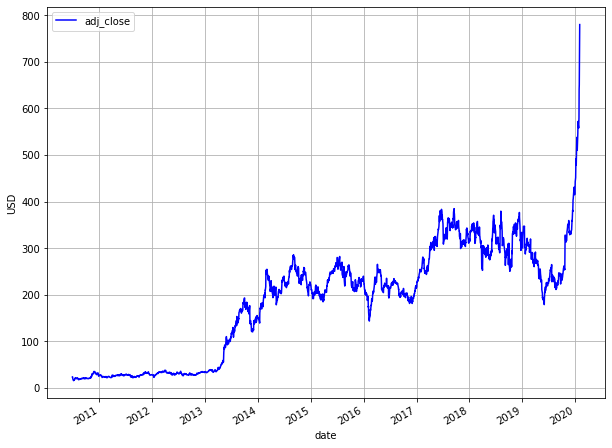

In [5]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Split into train, dev and test set

In [6]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1450
num_cv = 483
num_test = 483
train.shape = (1450, 8)
cv.shape = (483, 8)
train_cv.shape = (1933, 8)
test.shape = (483, 8)


# Scale the train, dev and test set and combine them to do feature engineering

In [7]:
# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['open', 'high', 'low', 'close', 'adj_close', 'volume']])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=['open', 'high', 'low', 'close', 'adj_close', 'volume'])
train_scaled[['date', 'month']] = train[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [1.17543165e+02 1.19728517e+02 1.15208938e+02 1.17526310e+02
 1.17526310e+02 4.22014531e+06]
scaler.var_ = [8.72927172e+03 9.00345185e+03 8.43638671e+03 8.72782906e+03
 8.72782906e+03 2.04600804e+13]
train_scaled.shape = (1450, 6)
train_scaled.shape = (1450, 8)


,open,high,low,close,adj_close,volume,date,month
0,-1.054721,-0.998335,-1.063355,-1.002285,-1.002285,3.215841,2010-06-29,6
1,-0.982046,-0.941214,-1.000644,-1.002927,-1.002927,2.866714,2010-06-30,6
2,-0.990502,-0.988639,-1.033632,-1.022944,-1.022944,0.884016,2010-07-01,7
3,-1.011908,-1.018359,-1.050617,-1.052487,-1.052487,0.203316,2010-07-02,7
4,-1.044018,-1.051029,-1.081972,-1.085562,-1.085562,0.585140,2010-07-06,7


In [8]:
# Do scaling for dev set
cv_scaled  = scaler.transform(cv[['open', 'high', 'low', 'close', 'adj_close', 'volume']])

# Convert the numpy array back into pandas dataframe
cv_scaled = pd.DataFrame(cv_scaled, columns=['open', 'high', 'low', 'close', 'adj_close', 'volume'])
cv_scaled[['date', 'month']] = cv.reset_index()[['date', 'month']]
print("cv_scaled.shape = " + str(cv_scaled.shape))
cv_scaled.head()

cv_scaled.shape = (483, 8)


,open,high,low,close,adj_close,volume,date,month
0,1.408285,1.395261,1.398273,1.385782,1.385782,2.046115,2016-04-04,4
1,1.316024,1.442054,1.358643,1.476552,1.476552,1.266460,2016-04-05,4
2,1.460195,1.559879,1.505077,1.583057,1.583057,1.654850,2016-04-06,4
3,1.593770,1.576741,1.516618,1.495070,1.495070,1.024932,2016-04-07,4
4,1.530086,1.486950,1.445959,1.418750,1.418750,0.695016,2016-04-08,4


In [9]:
# Do scaling for test set
test_scaled  = scaler.transform(test[['open', 'high', 'low', 'close', 'adj_close', 'volume']])

# Convert the numpy array back into pandas dataframe
test_scaled = pd.DataFrame(test_scaled, columns=['open', 'high', 'low', 'close', 'adj_close', 'volume'])
test_scaled[['date', 'month']] = test.reset_index()[['date', 'month']]
print("test_scaled.shape = " + str(test_scaled.shape))
test_scaled.head()

test_scaled.shape = (483, 8)


,open,high,low,close,adj_close,volume,date,month
0,2.299535,2.297708,2.330773,2.310181,2.310181,-0.087623,2018-03-05,3
1,2.314091,2.283164,2.306168,2.255055,2.255055,0.014493,2018-03-06,3
2,2.225148,2.242378,2.248574,2.298942,2.298942,0.174023,2018-03-07,3
3,2.304565,2.250809,2.297893,2.264689,2.264689,-0.144573,2018-03-08,3
4,2.210806,2.200117,2.255433,2.244030,2.244030,0.284452,2018-03-09,3


In [10]:
# Combine back train_scaled, cv_scaled, test_scaled together
df_scaled = pd.concat([train_scaled, cv_scaled, test_scaled], axis=0)
df_scaled.head()

,open,high,low,close,adj_close,volume,date,month
0,-1.054721,-0.998335,-1.063355,-1.002285,-1.002285,3.215841,2010-06-29,6
1,-0.982046,-0.941214,-1.000644,-1.002927,-1.002927,2.866714,2010-06-30,6
2,-0.990502,-0.988639,-1.033632,-1.022944,-1.022944,0.884016,2010-07-01,7
3,-1.011908,-1.018359,-1.050617,-1.052487,-1.052487,0.203316,2010-07-02,7
4,-1.044018,-1.051029,-1.081972,-1.085562,-1.085562,0.585140,2010-07-06,7


# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [11]:
# Get difference between high and low of each day
df_scaled['range_hl'] = df_scaled['high'] - df_scaled['low']
df_scaled.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df_scaled['range_oc'] = df_scaled['open'] - df_scaled['close']
df_scaled.drop(['open', 'close'], axis=1, inplace=True)

df_scaled.head()

,adj_close,volume,date,month,range_hl,range_oc
0,-1.002285,3.215841,2010-06-29,6,0.065020,-0.052436
1,-1.002927,2.866714,2010-06-30,6,0.059430,0.020881
2,-1.022944,0.884016,2010-07-01,7,0.044993,0.032442
3,-1.052487,0.203316,2010-07-02,7,0.032258,0.040578
4,-1.085562,0.585140,2010-07-06,7,0.030943,0.041544


Now we use lags up to N number of days to use as features.

In [12]:
# Add a column 'order_day' to indicate the order of the rows by date
df_scaled['order_day'] = [x for x in list(range(len(df_scaled)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [13]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df_scaled[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df_scaled, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df_scaled = pd.merge(df_scaled, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df_scaled = df_scaled[N:]
    
df_scaled.head()

C:\Users\ZeWu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_5,volume_lag_5,adj_close_lag_6,range_hl_lag_6,range_oc_lag_6,volume_lag_6,adj_close_lag_7,range_hl_lag_7,range_oc_lag_7,volume_lag_7
7,-1.071754,-0.037483,2010-07-09,7,0.000972,0.001835,7,-1.071112,0.007637,-0.014220,...,0.032442,0.884016,-1.002927,0.059430,0.020881,2.866714,-1.002285,0.065020,-0.052436,3.215841
8,-1.075500,-0.446058,2010-07-12,7,-0.002135,0.009541,8,-1.071754,0.000972,0.001835,...,0.040578,0.203316,-1.022944,0.044993,0.032442,0.884016,-1.002927,0.059430,0.020881,2.866714
9,-1.063833,-0.340471,2010-07-13,7,0.004961,-0.008120,9,-1.075500,-0.002135,0.009541,...,0.041544,0.585140,-1.052487,0.032258,0.040578,0.203316,-1.022944,0.044993,0.032442,0.884016
10,-1.045636,-0.005515,2010-07-14,7,0.011511,-0.020430,10,-1.063833,0.004961,-0.008120,...,0.006331,0.597255,-1.085562,0.030943,0.041544,0.585140,-1.052487,0.032258,0.040578,0.203316
11,-1.045101,-0.106194,2010-07-15,7,0.012238,0.000441,11,-1.045636,0.011511,-0.020430,...,-0.014220,0.771841,-1.088880,0.004681,0.006331,0.597255,-1.085562,0.030943,0.041544,0.585140


In [14]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2409 entries, 7 to 2415
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   adj_close        2409 non-null   float64       
 1   volume           2409 non-null   float64       
 2   date             2409 non-null   datetime64[ns]
 3   month            2409 non-null   int64         
 4   range_hl         2409 non-null   float64       
 5   range_oc         2409 non-null   float64       
 6   order_day        2409 non-null   int64         
 7   adj_close_lag_1  2409 non-null   float64       
 8   range_hl_lag_1   2409 non-null   float64       
 9   range_oc_lag_1   2409 non-null   float64       
 10  volume_lag_1     2409 non-null   float64       
 11  adj_close_lag_2  2409 non-null   float64       
 12  range_hl_lag_2   2409 non-null   float64       
 13  range_oc_lag_2   2409 non-null   float64       
 14  volume_lag_2     2409 non-null   float64

# Split the scaled features back into train, dev and test set

In [17]:
features = [
"adj_close_lag_1",
"range_hl_lag_1",
"range_oc_lag_1",
"volume_lag_1",
"adj_close_lag_2",
"range_hl_lag_2",
"range_oc_lag_2",
"volume_lag_2",
"adj_close_lag_3",
"range_hl_lag_3",
"range_oc_lag_3",
"volume_lag_3",
"adj_close_lag_4",
"range_hl_lag_4",
"range_oc_lag_4",
"volume_lag_4",
"adj_close_lag_5",
"range_hl_lag_5",
"range_oc_lag_5",
"volume_lag_5",
"adj_close_lag_6",
"range_hl_lag_6",
"range_oc_lag_6",
"volume_lag_6",
"adj_close_lag_7",
"range_hl_lag_7",
"range_oc_lag_7",
"volume_lag_7"
]

target = "adj_close"

# Split into train, cv, and test
train = df_scaled[:num_train]
cv = df_scaled[num_train:num_train+num_cv]
train_cv = df_scaled[:num_train+num_cv]
test = df_scaled[num_train+num_cv:]

# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (1450, 28)
y_train.shape = (1450,)
X_cv.shape = (483, 28)
y_cv.shape = (483,)
X_train_cv.shape = (1933, 28)
y_train_cv.shape = (1933,)
X_sample.shape = (476, 28)
y_sample.shape = (476,)


# EDA

Text(0, 0.5, 'USD (scaled)')

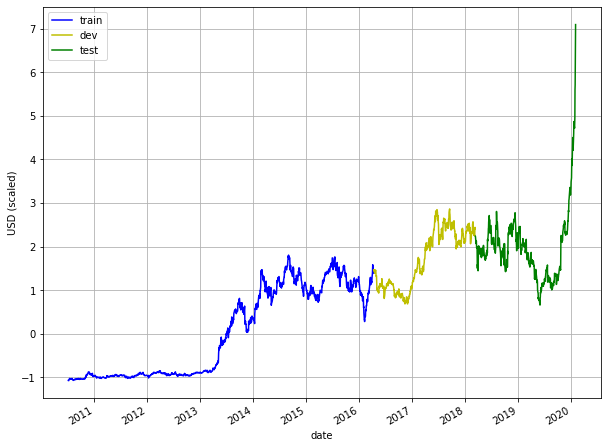

In [18]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")

# Train the model using XGBoost

In [19]:
# Create the model
model = XGBRegressor(seed=model_seed,
                      n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight)

# Train the regressor
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=100, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=100, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

# Predict on train set

In [20]:
# Do prediction on train set
est = model.predict(X_train)

# Calculate RMSE
math.sqrt(mean_squared_error(y_train, est))

0.032816598021486336

Text(0, 0.5, 'USD (scaled)')

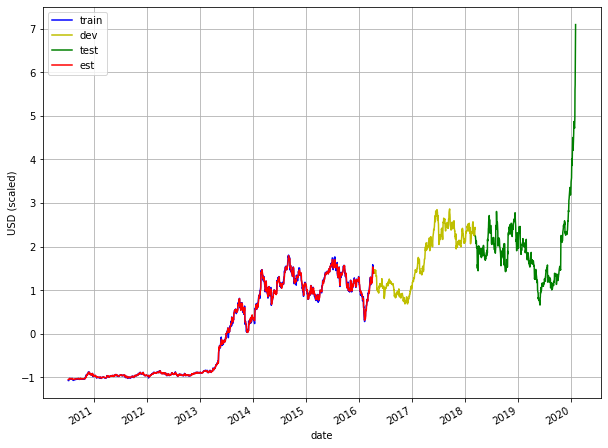

In [21]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")

# Predict on dev set

In [22]:
# Do prediction on test set
est = model.predict(X_cv)

# Calculate RMSE
math.sqrt(mean_squared_error(y_cv, est))

0.486846334979169